## Accessing Forest Inventory and Analysis data with the Planetary Computer STAC API

**Acknowledgement**: This notebook is adopted from notebook examples listed on Microsoft Planetar Computer. 

When talking about cloud computing, we may worry about accessing resources on different cloud environment. This notebook demonstrate the feasibility of accessing data from a different cloud platform. Our computing environment is built within Amazon Web Service but the data used in this notebook is from Microsoft Azure.

This notebook demonstrates accessing [Forest Inventory and Analysis](https://planetarycomputer.microsoft.com/dataset/fia) (FIA) data from the Planetary Computer STAC API.


### About Forest Inventory and Analysis data
The Forest Inventory and Analysis dataset is a nationwide survey of the forest assets of the United States. The FIA research program has been in existence since mandated by Congress in 1928. FIA's primary objective is to determine the extent, condition, volume, growth, and use of trees on the nation's forest land.

[FIA](https://planetarycomputer.microsoft.com/dataset/fia) data is located on Microsoft Azure in a collection of Parquet datasets. We can access the data directly from Azure. 

In [1]:
import dask.dataframe as dd
from adlfs import AzureBlobFileSystem

storage_account_name = 'cpdataeuwest'
folder_name = 'cpdata/raw/fia'

### Listing the data files
The full set of FIA data tables are available (e.g. tree, plot, condition). We can use <code>adlfs</code> to list the files:

In [2]:
fs = AzureBlobFileSystem(account_name=storage_account_name)
parquet_files = fs.glob(folder_name + '/*parquet')
print('Found {} Parquet files'.format(len(parquet_files)))
for k in range(0,20):
    print(parquet_files[k])
print('...')

Found 60 Parquet files
cpdata/raw/fia/boundary.parquet
cpdata/raw/fia/cond.parquet
cpdata/raw/fia/cond_dwm_calc.parquet
cpdata/raw/fia/county.parquet
cpdata/raw/fia/dwm_coarse_woody_debris.parquet
cpdata/raw/fia/dwm_duff_litter_fuel.parquet
cpdata/raw/fia/dwm_fine_woody_debris.parquet
cpdata/raw/fia/dwm_microplot_fuel.parquet
cpdata/raw/fia/dwm_residual_pile.parquet
cpdata/raw/fia/dwm_transect_segment.parquet
cpdata/raw/fia/dwm_visit.parquet
cpdata/raw/fia/grnd_cvr.parquet
cpdata/raw/fia/invasive_subplot_spp.parquet
cpdata/raw/fia/lichen_lab.parquet
cpdata/raw/fia/lichen_plot_summary.parquet
cpdata/raw/fia/lichen_visit.parquet
cpdata/raw/fia/ozone_biosite_summary.parquet
cpdata/raw/fia/ozone_plot.parquet
cpdata/raw/fia/ozone_plot_summary.parquet
cpdata/raw/fia/ozone_species_summary.parquet
...


### Opening one data file
Here we demonstrate how to open the <code>condition</code> dataset. This may take a minute or so to open given the size of the data.


In [4]:
%%time
df = dd.read_parquet('az://' + folder_name + '/cond.parquet',
                     storage_options={'account_name':storage_account_name}).compute()
df

CPU times: user 9.8 s, sys: 4.57 s, total: 14.4 s
Wall time: 1min 3s


,CN,PLT_CN,INVYR,STATECD,UNITCD,COUNTYCD,PLOT,CONDID,COND_STATUS_CD,COND_NONSAMPLE_REASN_CD,...,TRTOPCD,TRTYR1_P2A,TRTYR2_P2A,TRTYR3_P2A,LAND_COVER_CLASS_CD,SIEQN_REF_CD,SICOND_FVS,SIBASE_FVS,SISP_FVS,SIEQN_REF_CD_FVS
0,257087026010854,236617010010854,2011,1,1,3,215,1,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,258624640010854,236617012010854,2011,1,1,3,42,1,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,256996505010854,236617014010854,2011,1,6,89,83,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,103.0,50.0,621.0,LITU07
3,256996506010854,236617014010854,2011,1,6,89,83,2,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,256996507010854,236617014010854,2011,1,6,89,83,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,103.0,50.0,621.0,LITU07


<code>df</code> has nearly 200,000 rows of data with more than 150 different variables which is a very large table!

### Plot data

Here we make a quick plot comparing the stand age to the alive basal area.

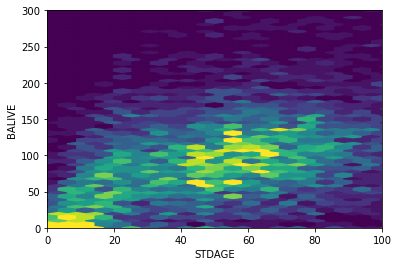

In [14]:
ax = df[::100].plot.hexbin('STDAGE', 'BALIVE', gridsize=(300, 100),
                           vmax=20, cmap='viridis', colorbar=False)
ax.set_ylim(0, 300)
ax.set_xlim(0, 100);

### Open FIA Data via STAC API

The FIA collection on Microsoft contains many tables, and each STAC table corresponds to one STAC item in the [FIA collection](http://planetarycomputer.microsoft.com/api/stac/v1/collections/fia). In this example, we'll use a few of the tables to estimate the total amount of aboveground carbon, in pounds, per US county.

This example builds on the [plot estimation](https://rfia.netlify.app/courses/plt_est/) example from the [rfia](https://rfia.netlify.app/) package.

More about [SpatialTemporal Asset Catalogs (STAC)](http://stacspec.org/) - STAC allows data provider (like Microsoft) to cataloging the data in a standard way and make it easy to be indexed and discovered by users like us. Microsoft has a [STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) that makes data discovery easy.

Before we explore FIA example, let's just take a quick look of other data via its STAC API.


In [15]:
from pystac_client import Client

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

This gets us a STAC Catalog that we can crawl or search. The Catalog contains STAC Collections for each dataset we have indexed (which is not the yet the entirity of data hosted by the Planetary Computer). Here we list the collection IDs and titles that are available:

In [16]:
collections = catalog.get_children()
for collection in collections:
    print(f"{collection.id} - {collection.title}")

gap - USGS Gap Land Cover
nasadem - NASADEM HGT v001
daymet-annual-na - Daymet Annual North America
hrea - HREA: High Resolution Electricity Access
daymet-monthly-hi - Daymet Monthly Hawaii
daymet-daily-na - Daymet Daily North America
daymet-monthly-na - Daymet Monthly North America
daymet-annual-pr - Daymet Annual Puerto Rico
daymet-daily-pr - Daymet Daily Puerto Rico
daymet-daily-hi - Daymet Daily Hawaii
daymet-monthly-pr - Daymet Monthly Puerto Rico
aster-l1t - ASTER L1T
daymet-annual-hi - Daymet Annual Hawaii
io-lulc - Esri 10-Meter Land Cover
jrc-gsw - JRC Global Surface Water
landsat-8-c2-l2 - Landsat 8 Collection 2 Level-2
mobi - MoBI: Map of Biodiversity Importance
mtbs - MTBS: Monitoring Trends in Burn Severity
terraclimate - TerraClimate
sentinel-2-l2a - Sentinel-2 Level-2A
us-census - US Census
cop-dem-glo-30 - Copernicus DEM GLO-30
cop-dem-glo-90 - Copernicus DEM GLO-90
fia - Forest Inventory and Analysis
gbif - Global Biodiversity Information Facility (GBIF)
goes-cmi - GOE

Now let's get back to focus on FIA data before we get too distracted. But you can explore the use of other data on Microsoft by following the associated examples.

Let's first set up the environment that we need!

In [17]:
from cartopy import crs as ccrs
from dask_gateway import GatewayCluster
import dask_geopandas
import dask.dataframe as dd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


The `tree` table below is relatively large, so we'll process it in parallel on a Dask cluster. The example will still run without a cluster, it will just take longer. To spin up the Dask cluster, it will take about 3-5 minutes. So please be patient.

In [18]:
cluster = GatewayCluster()
cluster.scale(8)
client = cluster.get_client()
cluster

By clicking on the link for dashboard, we can check the status of our cluster. We also add it to the client in this window (third icon on the left).

### Accessing FIA data via STAC API

We'll use two datsaets

* `tree`: Information on each tree which is at least 1″ in diameter, linked to `plot` and `cond`.
* `plot`: Information relevant to each 1-acre field plot where the samples were collected.

All of these are available in Azure Blob Storage as parquet datasets that can be read, for example, by `dask.dataframe`.

In [19]:
import pystac_client

catalog = pystac_client.Client.open(
    "http://planetarycomputer.microsoft.com/api/stac/v1"
)
fia = catalog.get_collection("fia")
fia

<CollectionClient id=fia>

We need to sign the items before trying to access the data.

In [20]:
plot_item = planetary_computer.sign(fia.get_item("plot"))
tree_item = planetary_computer.sign(fia.get_item("tree"))

And now we can read the items using `dask.dataframe`. We make sure to pass the `storage_options` included in the `data` asset.

In [21]:
plot = dd.read_parquet(
    plot_item.assets["data"].href,
    columns=["CN", "STATECD", "COUNTYCD"],
    storage_options=plot_item.assets["data"].extra_fields["table:storage_options"],
    engine="pyarrow",
)
tree = dd.read_parquet(
    tree_item.assets["data"].href,
    columns=["PLT_CN", "CONDID", "TREE", "DRYBIO_AG", "CARBON_AG", "TPA_UNADJ"],
    storage_options=tree_item.assets["data"].extra_fields["table:storage_options"],
    engine="pyarrow",
    filters=[("CONDID", "==", 1)],
)

### Join the datasets

The three datasets can be joined on their various keys. Since `tree` is relatively large, we'll join the other (smaller, in-memory) dataframes to it.

In [22]:
df = tree.merge(plot.assign(PLT_CN=plot.CN).compute(), on="PLT_CN").assign(
    bio=lambda df: df.DRYBIO_AG * df.TPA_UNADJ / 2000,
    carbon=lambda df: df.CARBON_AG * df.TPA_UNADJ / 2000,
)
df.head()

,PLT_CN,CONDID,TREE,DRYBIO_AG,CARBON_AG,TPA_UNADJ,CN,STATECD,COUNTYCD,bio,carbon
0,157499420010854,1,1,289.953118,144.976559,6.608,157499420010854,1,3,0.958005,0.479003
1,157499420010854,1,2,720.096826,360.048413,4.775,157499420010854,1,3,1.719231,0.859616
2,157499420010854,1,3,91.298929,45.649465,15.784,157499420010854,1,3,0.720531,0.360266
3,157499420010854,1,4,527.626470,263.813235,5.481,157499420010854,1,3,1.445960,0.722980
4,157499420010854,1,5,555.487894,277.743947,4.938,157499420010854,1,3,1.371500,0.685750


### Compute per-county summaries

The `df` dataframe now includes the state and county FIPS codes, and the (adjusted) aboveground carbon and biomass. We'll group by the geographic boundaries and summarize the aboveground carbon and biomass.

In [23]:
%%time
result = (
    df.groupby(["STATECD", "COUNTYCD"])[["bio", "carbon"]]
    .sum()
    .compute()
    .reset_index()
    .assign(
        STATE=lambda df: df["STATECD"].astype("string").str.pad(2, fillchar="0"),
        COUNTY=lambda df: df["COUNTYCD"].astype("string").str.pad(3, fillchar="0"),
    )
    .drop(columns=["STATECD", "COUNTYCD"])
)
result.head()

CPU times: user 135 ms, sys: 51 ms, total: 186 ms
Wall time: 36.3 s


,bio,carbon,STATE,COUNTY
0,9130.179946,4565.090000,01,001
1,27163.826785,13565.771340,01,003
2,15567.843806,7774.593220,01,005
3,16643.533828,8321.766954,01,007
4,8742.498366,4364.876867,01,009


### Plot the results

Now we'll make a chloropleth map for the results of the county data summary. We just need to join in the actual geographic boundaries of the datasets, which we can get with geopandas.

In [24]:
census_item = planetary_computer.sign(
    catalog.get_collection("us-census").get_item("2020-cb_2020_us_county_500k")
)

counties = (
    dask_geopandas.read_parquet(
        census_item.assets["data"].href,
        storage_options=census_item.assets["data"].extra_fields[
            "table:storage_options"
        ],
        columns=["STATEFP", "COUNTYFP", "geometry"],
    ).rename(columns={"STATEFP": "STATE", "COUNTYFP": "COUNTY"})
).compute()

Finally, we'll slice the data down to the continental United States (the dataset covers Hawaii, Alaska, and several other territories).

In [25]:
gdf = geopandas.GeoDataFrame(pd.merge(result, counties, on=["STATE", "COUNTY"]))
df_conus = gdf.cx[-124.784:-66.951, 24.744:49.346]
df_conus.head()

,bio,carbon,STATE,COUNTY,geometry
0,9130.179946,4565.090000,01,001,"POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
1,27163.826785,13565.771340,01,003,"POLYGON ((-88.02858 30.22676, -88.02399 30.230..."
2,15567.843806,7774.593220,01,005,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
3,16643.533828,8321.766954,01,007,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
4,8742.498366,4364.876867,01,009,"POLYGON ((-86.96336 33.85822, -86.95967 33.857..."


Finally, we'll plot the (log) of the estimated carbon stored above ground by the trees.

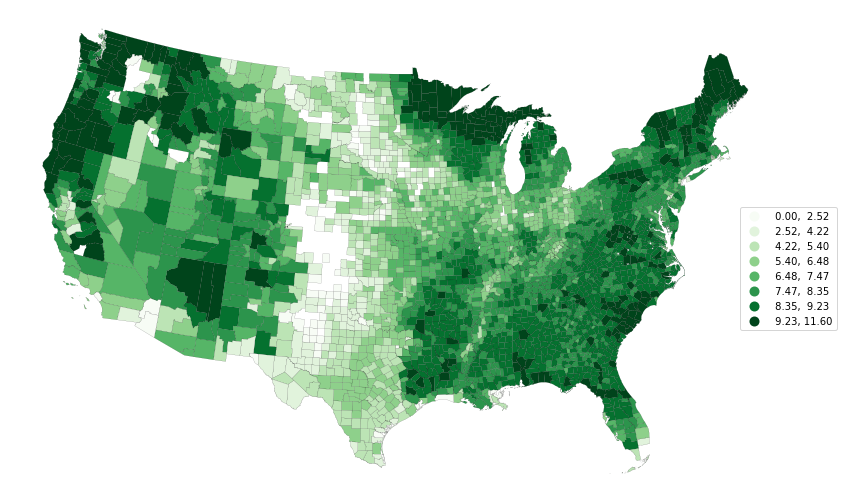

In [26]:
crs = ccrs.LambertConformal()
fig, ax = plt.subplots(subplot_kw={"projection": crs}, figsize=(16, 9))
df_conus.assign(carbon=np.log(df_conus.carbon + 1)).to_crs(crs.proj4_init).plot(
    column="carbon",
    cmap="Greens",
    edgecolor="k",
    scheme="natural_breaks",
    k=8,
    ax=ax,
    linewidths=0.1,
    legend=True,
)

# Shift the legend
bbox = ax.legend_.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
bbox.x0 += 0.075
bbox.x1 += 0.075
bbox.y0 -= 0.4
bbox.y1 -= 0.4
ax.legend_.set_bbox_to_anchor(bbox)

ax.axis("off");

### Close down the cluster

Close down the cluster to save the cost.

In [27]:
cluster.shutdown()